# Circulating plasma miRNA biomarker selection using RFE

## Author: Shehbeel Arif

## Purpose: To find a set of circulating miRNAs most predictive of Low-grade Glioma relapse in platient blood plasma samples.

---

## Load libraries

In [103]:
# Library for data handling
import numpy as np
import pandas as pd

# Library for performing RFE
from sklearn.pipeline import Pipeline
#from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
#from sklearn.feature_selection import RFE

# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# Import Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

# Import sklearn library to assess model accuracy
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from statistics import mean, stdev


# Library for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from umap.umap_ import UMAP

## Data Preprocessing

In [24]:
# Load data
data_dir = '/Users/shehbeel/Documents/liquid-biopsy-analysis/data/'
meta = pd.read_csv(data_dir + 'lb_metadata.csv')
counts = pd.read_csv(data_dir + 'lb_plasma_matrix.csv', index_col='gene')

# Select only LGG samples
meta = meta[meta['Short_Histology'] == 'LGG']

# Transpose counts
counts = counts.iloc[:2102,]
counts = counts.T
counts = counts.reset_index()

# Merge counts and meta data
df = pd.merge(meta, counts, left_on='SDG_ID', right_on='index').drop(['index'], axis=1)

# Sanity check
df

,SDG_ID,CSF_Specimen,Plasma_Specimen,Diagnosis,Short_Histology,Tumor_Subtype,Relapse,Survival_Status,CTRL_ANT1,CTRL_ANT2,...,miR-944,miR-95-3p,miR-95-5p,miR-9-5p,miR-96-3p,miR-96-5p,miR-98-3p,miR-99a-5p,miR-99b-3p,miR-99b-5p
0,15635-37,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,Yes,Alive,16.0,16.0,...,23.0,44.0,31.0,19.0,21.0,125.0,38.0,891.0,75.0,290.0
1,15635-46,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,No,Alive,41.0,60.0,...,11.0,99.0,172.0,67.0,35.0,62.0,118.0,1972.0,143.0,596.0
2,15635-60,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,No,Alive,12.0,68.0,...,53.0,98.0,127.0,28.0,104.0,20.0,123.0,1020.0,174.0,370.0
3,15635-68,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,No,Alive,99.0,86.0,...,61.0,190.0,162.0,98.0,75.0,256.0,67.0,1842.0,168.0,1263.0
4,15635-80,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,No,Alive,56.0,87.0,...,68.0,82.0,142.0,65.0,55.0,263.0,37.0,377.0,217.0,960.0
5,15635-90,False,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,Yes,Alive,69.0,52.0,...,40.0,84.0,56.0,81.0,73.0,168.0,46.0,3492.0,155.0,282.0
6,15635-100,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,Yes,Alive,0.0,17.0,...,0.0,57.0,62.0,24.0,22.0,120.0,72.0,3586.0,73.0,919.0
7,15635-101,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,No,Alive,39.0,30.0,...,39.0,62.0,92.0,39.0,27.0,126.0,33.0,1508.0,64.0,254.0
8,15635-127,False,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,Yes,Alive,16.0,6.0,...,7.0,28.0,50.0,38.0,10.0,113.0,27.0,865.0,44.0,335.0
9,15635-134,False,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic/pilomyxoid astrocytoma,Yes,Alive,28.0,50.0,...,60.0,147.0,104.0,40.0,31.0,180.0,75.0,2621.0,154.0,1349.0


In [46]:
# Split the dataset into training data and labels
X = df.iloc[:,27:].values
y = df.loc[:, df.columns == 'Relapse'].values.ravel()

# Save feature names
columns = df.columns.to_list()
features = columns[27:]

# Sanity check
print(X[:5])
print(y[:5])

[[  178.    69.  7346. ...   891.    75.   290.]
 [  480.    43.  8435. ...  1972.   143.   596.]
 [  740.    73.  1372. ...  1020.   174.   370.]
 [  481.    79. 18243. ...  1842.   168.  1263.]
 [ 3358.    89.  3032. ...   377.   217.   960.]]
['Yes' 'No' 'No' 'No' 'No']


In [91]:
# Library for splitting data into Training and Testing datasets
from sklearn.model_selection import train_test_split

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)

#Sanity check
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8, 2083) (2, 2083) (8,) (2,)


---

## Visualize the data

/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


<AxesSubplot:xlabel='0', ylabel='1'>

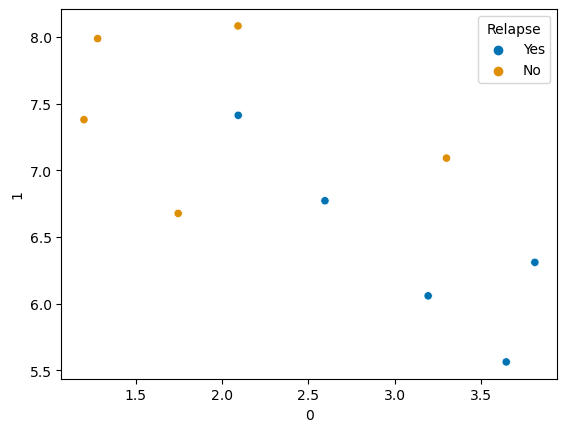

In [93]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(X)
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.Relapse, palette="colorblind")

---

## Random Forest (CV)

In [105]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
lst_accu_stratified = []

rfc = RandomForestClassifier(max_depth=3, random_state=123)

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    rfc.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(rfc.score(x_test_fold, y_test_fold))
  
# Print the output
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [1.0, 0.5, 1.0, 0.5, 1.0]

Maximum Accuracy That can be obtained from this model is: 100.0 %

Minimum Accuracy: 50.0 %

Overall Accuracy: 80.0 %

Standard Deviation is: 0.27386127875258304


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

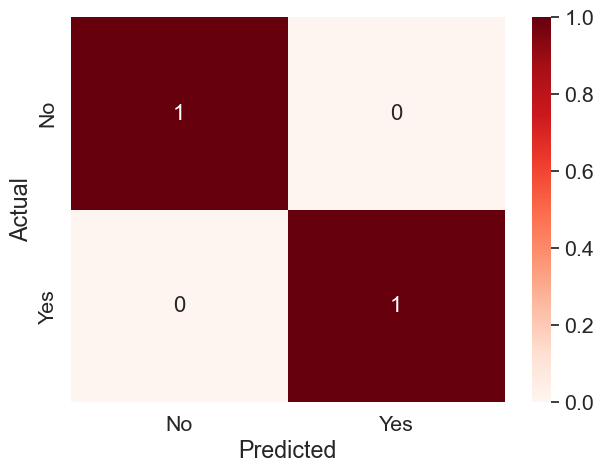

In [125]:
# Build confusion matrix
y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [162]:
# What are the most important features?
feature_list = df.iloc[:,27:].columns
#feature_list = feature_list.drop(['sample_name', 'gender', 'treatment'])

imp_features = pd.Series(rfc.feature_importances_, index=feature_list)

imp_genes = imp_features.sort_values(ascending=False).to_frame().reset_index()
imp_genes.columns = ["features", "importance"]

rfc_imp_genes = imp_genes[~(imp_genes == 0.000000).any(axis=1)]
rfc_imp_genes

,features,importance
0,miR-4686,0.030
1,miR-3127-5p,0.020
2,miR-4735-5p,0.020
3,miR-578,0.020
4,miR-4725-3p,0.020
...,...,...
88,miR-656-3p,0.006
89,miR-5692c,0.006
90,miR-4511,0.004
91,miR-212-5p,0.004


/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Text(0, 0.5, 'UMAP2')

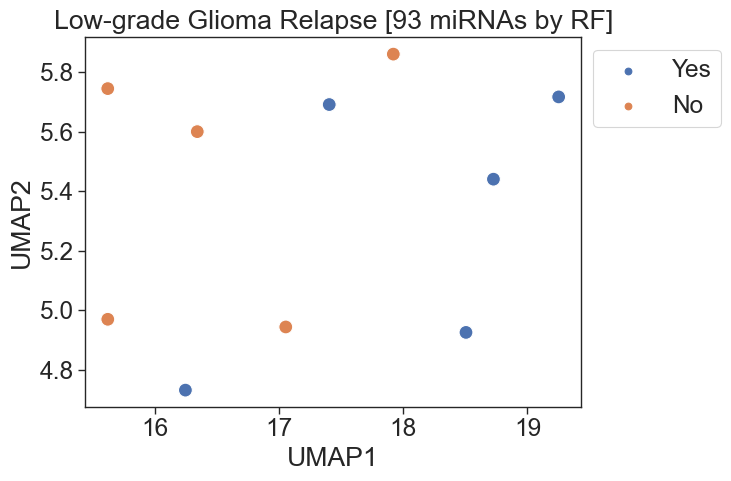

In [203]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df[rfc_imp_genes.features.to_list()])
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.Relapse, palette="deep", s=100)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Low-grade Glioma Relapse [93 miRNAs by RF]')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

---

## Logistic Regression (CV)

In [117]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
lst_accu_stratified = []

lr = LogisticRegression(max_iter=40, random_state=123)

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    lr.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(rfc.score(x_test_fold, y_test_fold))
  
# Print the output
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [1.0, 1.0, 1.0, 1.0, 1.0]

Maximum Accuracy That can be obtained from this model is: 100.0 %

Minimum Accuracy: 100.0 %

Overall Accuracy: 100.0 %

Standard Deviation is: 0.0


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

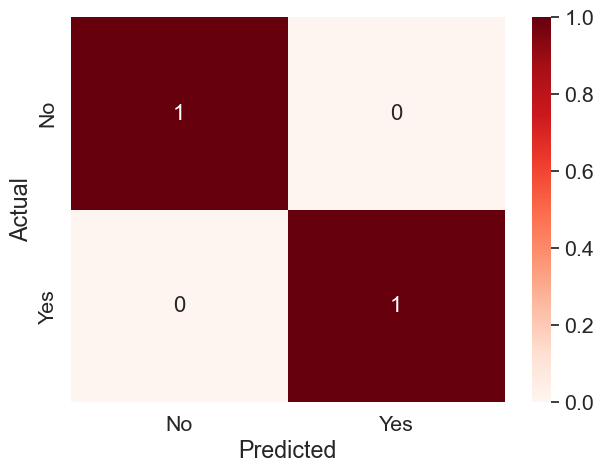

In [119]:
# Build confusion matrix
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [166]:
# What are the most important features?
feature_list = df.iloc[:,27:].columns

imp_features = pd.Series(lr.coef_[0], index=feature_list)

imp_genes = imp_features.sort_values(ascending=False).to_frame().reset_index()
imp_genes.columns = ["features", "importance"]

#imp_genes_fil = imp_genes[(imp_genes.importance > 0.00001) | (imp_genes.importance < -0.00001)]
imp_genes_fil = imp_genes.iloc[imp_genes['importance'].abs().argsort()].reset_index(drop=True)
lr_genes_100 = imp_genes_fil.tail(100)
lr_genes_100

,features,importance
1983,let-7f-5p,0.000004
1984,miR-6124,-0.000004
1985,miR-4429,-0.000004
1986,let-7g-3p,-0.000004
1987,miR-3677-5p,-0.000004
...,...,...
2078,miR-451a,0.000064
2079,miR-6870-3p,-0.000064
2080,miR-671-5p,-0.000070
2081,miR-223-3p,0.000102


/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Text(0, 0.5, 'UMAP2')

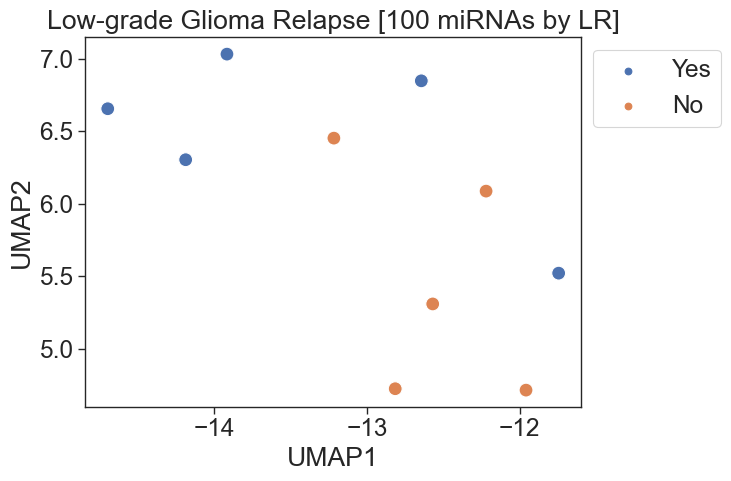

In [204]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df[lr_genes_100['features'].to_list()])
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.Relapse, palette="deep", s=100)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Low-grade Glioma Relapse [100 miRNAs by LR]')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

In [170]:

mirna_intersected = list(set(rfc_imp_genes.features.to_list()) & set(lr_genes_100.features.to_list()))
mirna_intersected

['miR-6069',
 'miR-106b-5p',
 'miR-4793-5p',
 'miR-20a-5p',
 'miR-451a',
 'miR-3943',
 'miR-19a-3p',
 'miR-6825-3p',
 'miR-3157-5p',
 'miR-17-5p',
 'miR-6741-5p']

/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


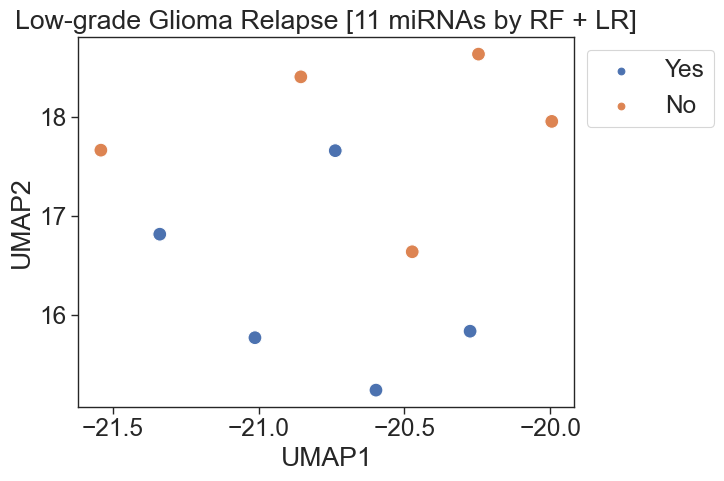

In [206]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df[mirna_intersected])
proj_2d = pd.DataFrame(proj_2d)

#sns.set_style(style='ticks')
#sns.set_context('paper', font_scale = 2) # 'poster'

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.Relapse, palette="deep", s=100)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Low-grade Glioma Relapse [11 miRNAs by RF + LR]')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.show()

---